In [7]:
import os, glob
import json
from tqdm import tqdm
import pickle #This library will maintain the format as well

from PIL import Image
import radiometric_calib_utils as rcu
import mutils
import extract_spectral as espect
import algorithms.Hedley as Hedley
# import algorithms.SUGAR as sugar
import algorithms.Goodman as Goodman
import algorithms.Kutser_2013 as Kutser2013
import algorithms.validate_algorithm as ValidateAlgo
import algorithms.uncertainty_estimation as uncertainty
import algorithms.flight_attributes as FlightAttributes

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from math import ceil
import scipy
import cv2
import importlib
import algorithms.SUGAR
importlib.reload(algorithms.SUGAR)
import algorithms.SUGAR as sugar

![SUGAR](images/sugar_graphical_abstract.jpg)

# Generate reflectance image with MicaSense UAV imagery

- Radiometric calibration and correction is conducted
- A calibrated linear regression relating to panel irradiance DLS irradiance has been established in `saved_data/dls_panel_irr_calibration.ob` for radiometric correction
- Or, optionally use the default micasense image processing toolbox (for micasense imagery) to get the reflectance image
- The required input that SUGAR requires is a numpy array of $(m,n,c)$, where $m, n$ are the spatial dimensions of the image, and $c$ is the number of channels of the image (applicable for multispectral/hyperspectral images)

In [8]:
image_fp = r"example_images\IMG_0192_1.tif"
cap = mutils.import_captures(image_fp)
RI = espect.ReflectanceImage(cap)
im_aligned = RI.get_aligned_reflectance()

Shape of input to SUGAR: (919, 1226, 10)


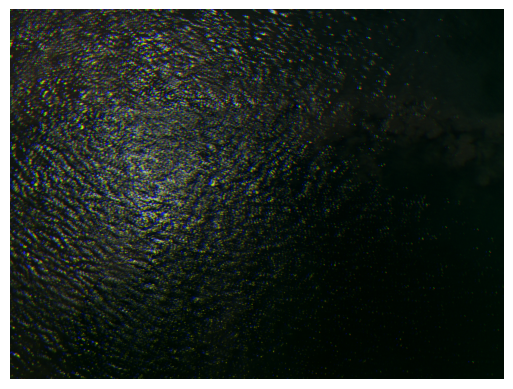

In [9]:
print(f'Shape of input to SUGAR: {im_aligned.shape}')
_ = mutils.get_rgb(im_aligned, normalisation=True)

## Apply SUGAR on reflectance image with image prior

- Indicate the number of iterations (3 iterations is recommended)
- SUGAR outputs a list of corrected image for each iteration, where iteration 0 corresponds to the uncorrected image
- e.g. `corrected_bands[0]` corresponds to uncorrected image
- `corrected_bands[1]` corresponds to corrected image for iteration 1
- `corrected_bands[-1]` corresponds to final corrected image for the last iteration
- Choose between different glint mask method: `otsu` or `cdf`. `otsu` is an adaptive method that typically produces better results, but `cdf` allows for faster processing

### The cdf method

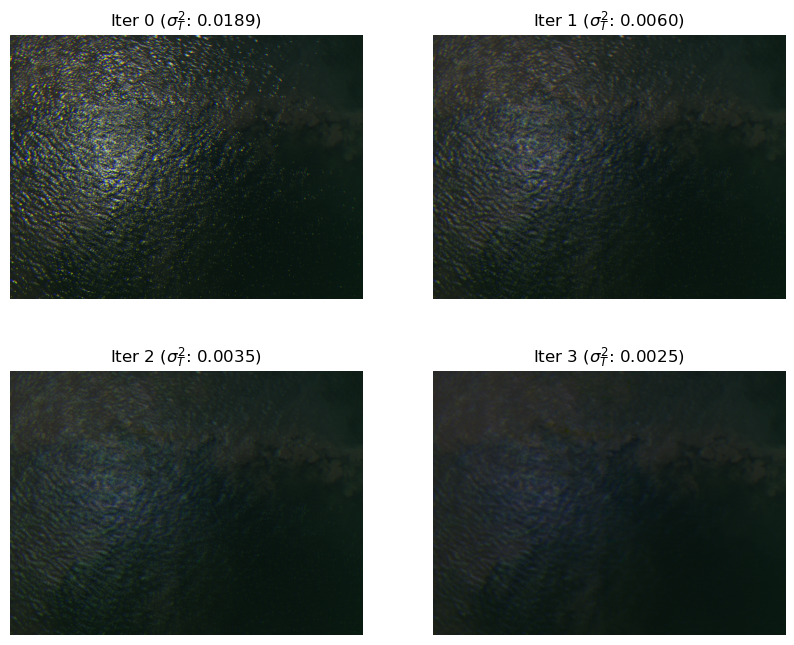

In [10]:
corrected_bands = sugar.correction_iterative(im_aligned,
                                             iter=3,
                                             estimate_background=True,
                                             glint_mask_method="cdf",
                                             plot=True)

In [11]:
print(f'length of output: {len(corrected_bands)}')
print(f'Shape of each output: {corrected_bands[0].shape}')

length of output: 4
Shape of each output: (919, 1226, 10)


### The Otsu method

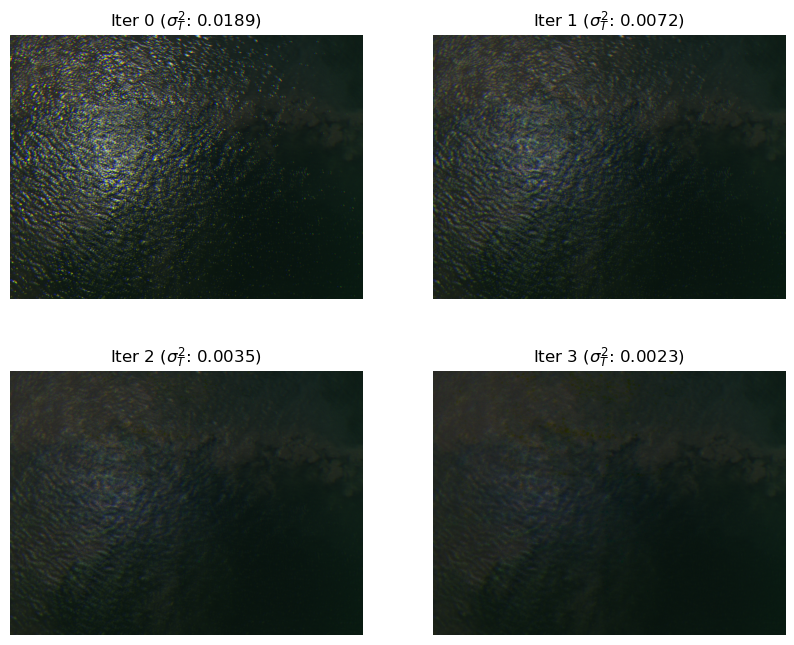

In [12]:
corrected_bands = sugar.correction_iterative(im_aligned,
                                             iter=3,
                                             estimate_background=True,
                                             glint_mask_method="otsu",
                                             plot=True)

### Another variation of SUGAR without estimation of image prior

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


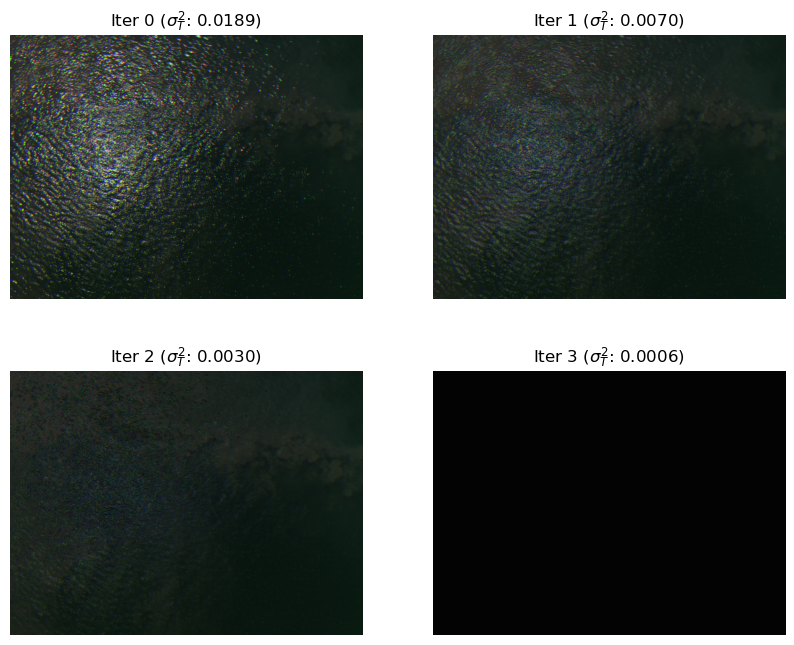

In [34]:
corrected_bands = sugar.correction_iterative(im_aligned,iter=3,estimate_background=False,plot=True)

### Extract Glint Mask by SUGAR (optional)
- shape of glint mask should correspond to the shape of the input
- $1$ represents presence of *glint*, and $0$ represents *no glint*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


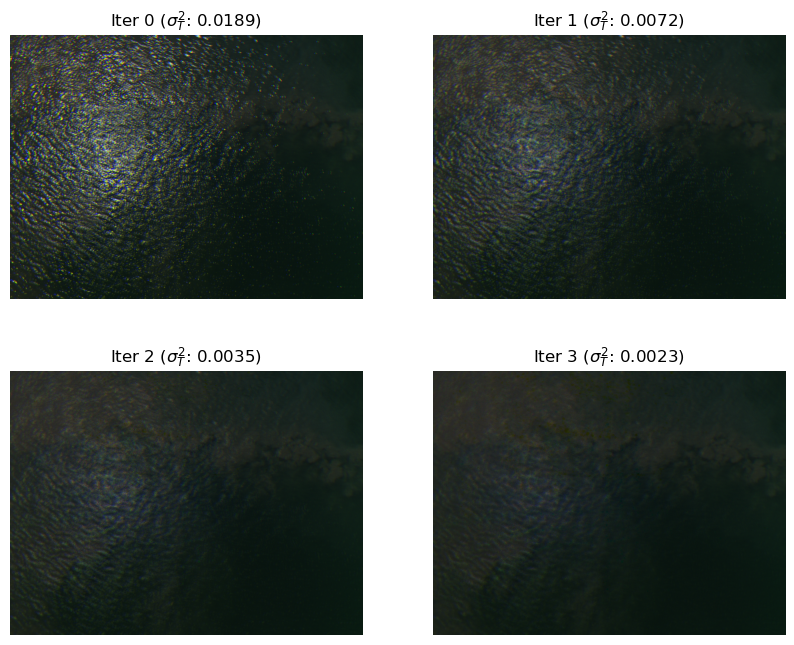

In [25]:
corrected_bands,glint_mask = sugar.correction_iterative(im_aligned,iter=3,plot=True, get_glint_mask=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of mask: (919, 1226, 10)


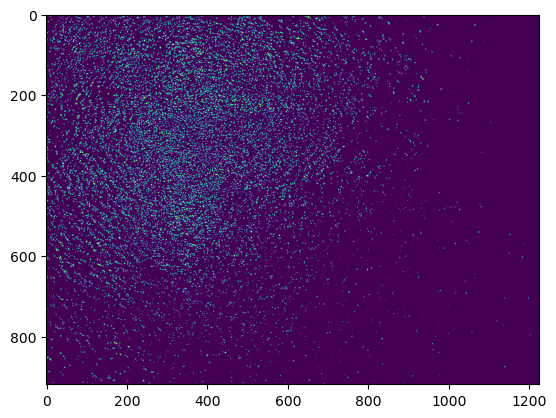

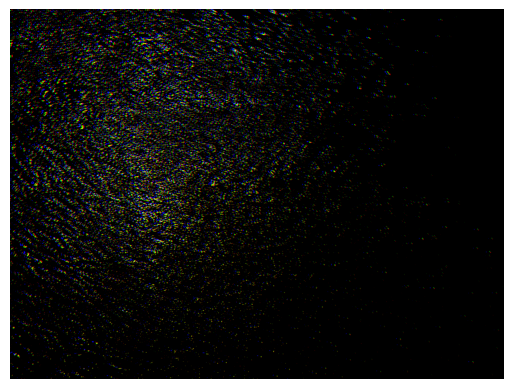

In [23]:
# show glint classification
plt.imshow(glint_mask[:,:,0])
print(f'Shape of mask: {glint_mask.shape}')

# extract glint reflectance
extracted_glint = glint_mask*corrected_bands[0]
_ = mutils.get_rgb(extracted_glint)

# Conduct SUGAR on GLORIA simulated images

- Simulate different types of water bodies in arg `water_type`
    - 1: sediment-dominated
    - 2: chl-dominated
    - 3: CDOM-dominated
    - 4: Chl+CDOM-dominated
    - 5: Moderate turbid coastal (e.g., 0.3<TSS<1.2 & 0.5<Chl<2.0)
    - 6: Clear (e.g., TSS<0.3 & 0.1<Chl<0.7)
    - e.g. in the `water_type` argument, one can specify a list of water bodies, e.g. `water_type = [2,3]`


- Outputs:
    - $R_{BG}$: simulated background spectra of the water type
    - $R_{T}$: simulated reflectance, a linear combination of $R_{BG}$ and the glint image specified by `glint_fp`
    - $R_T'$: Corrected sun glint without image prior (accounting for background spectra)
    - $R_{T,BG}'$: Corrected sun glint with image prior

n_rrs:3, scale:4, rotation: 72, strength: 9, radius: 75
nrows in df: 375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


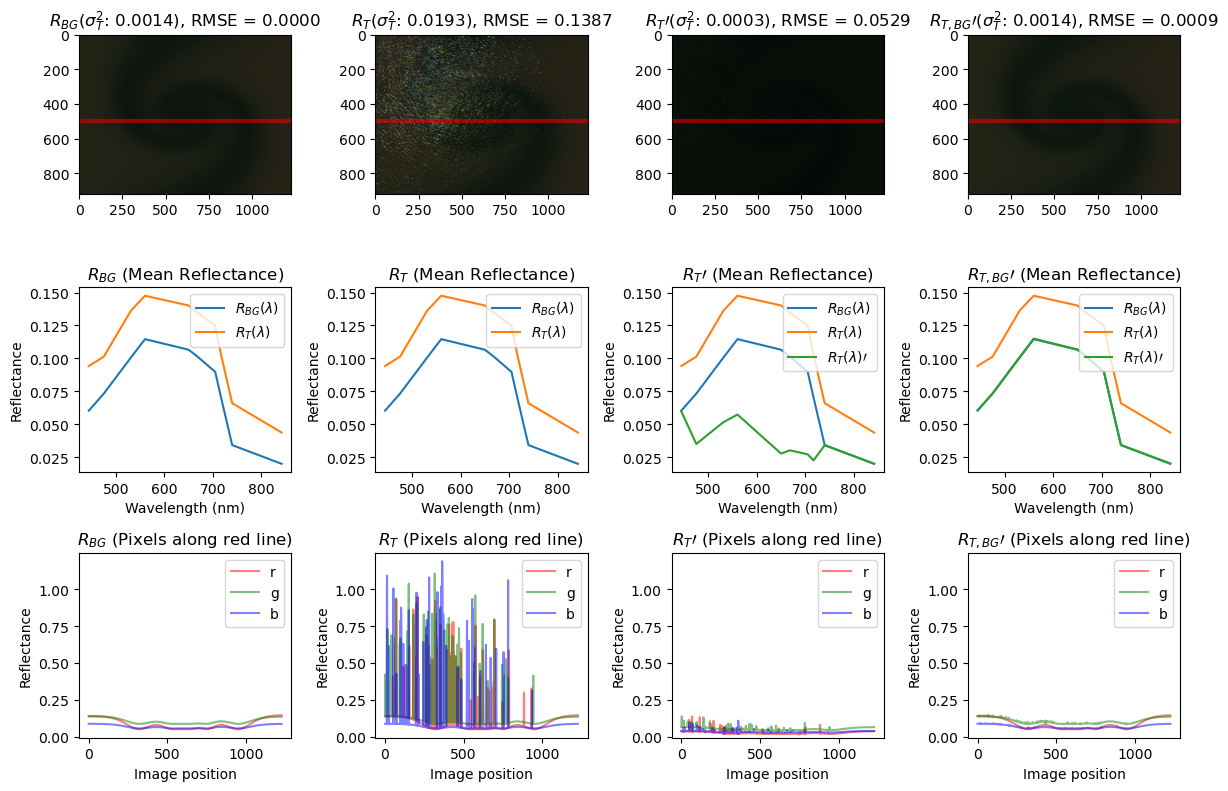

In [29]:
np.random.seed(1)
SB = ValidateAlgo.SimulateBackground(glint_fp=r"saved_data\example_glint.ob",
                                    fp_rrs = r"GLORIA_2022\GLORIA_Rrs_mean.csv",
                                    fp_meta = r"GLORIA_2022\GLORIA_meta_and_lab.csv",
                                    water_type=[1,5],
                                    estimate_background=False, iter=3,
                                    y_line=500)
im_list = SB.simulation()

In [31]:
print(f'Keys of output: {im_list.keys()}')

Keys of output: dict_keys(['R_BG', 'R_T', 'R_prime_T', 'R_prime_T_BG'])


# Compare SUGAR with other algorithms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


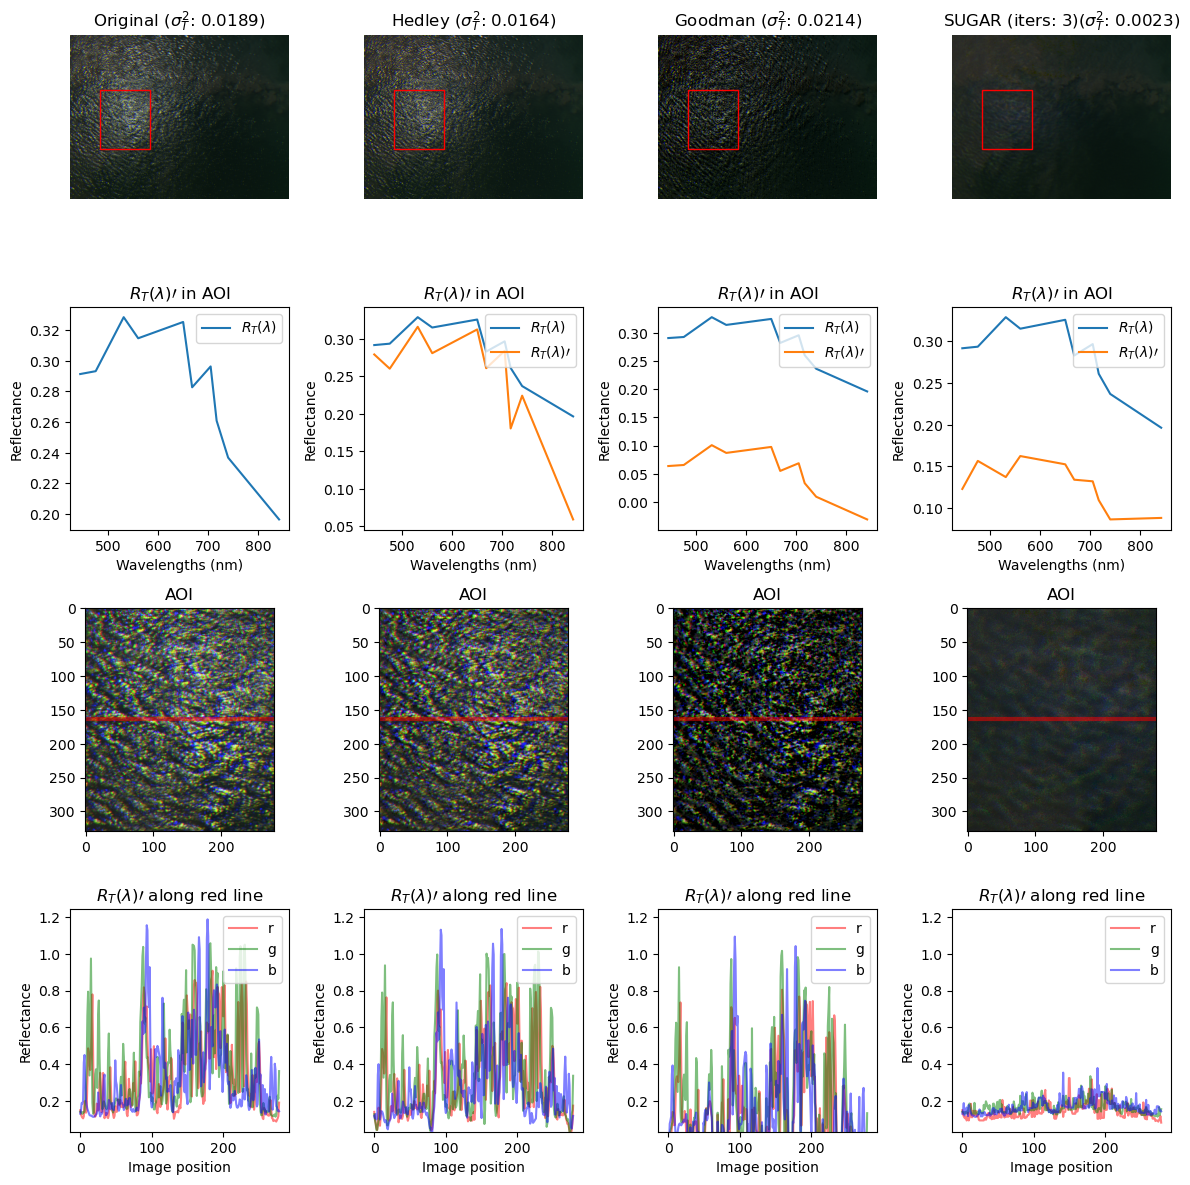

In [33]:
ValidateAlgo.compare_correction_algo(im_aligned,
                                     bbox=[[166, 306], [445, 635]],
                                     corrected_SUGAR=corrected_bands,
                                     iter=3)

# Quantify uncertainties

- Prepares the entire pipeline of SUGAR correction when provided with the reflectance image `im_aligned`
- provides qualification and quantification of uncertainty estimates
- Run the following code for the entire pipeline

In [34]:
UE = uncertainty.UncertaintyEst.get_corrected_image(im_aligned)

### KDE of glint distribution

- provides a qualification of the probability of glint presence in the image
- higher uncertainty will be present in regions with high density of glint

(2, 45264)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


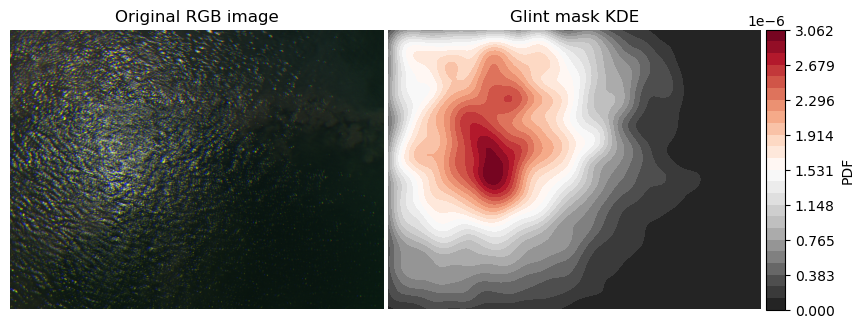

In [36]:
kde_glint = UE.get_glint_kde()

In [39]:
print(f'shape of KDE glint: {kde_glint.shape}')

shape of KDE glint: (919, 1226)


### Quantification of uncertainties by band

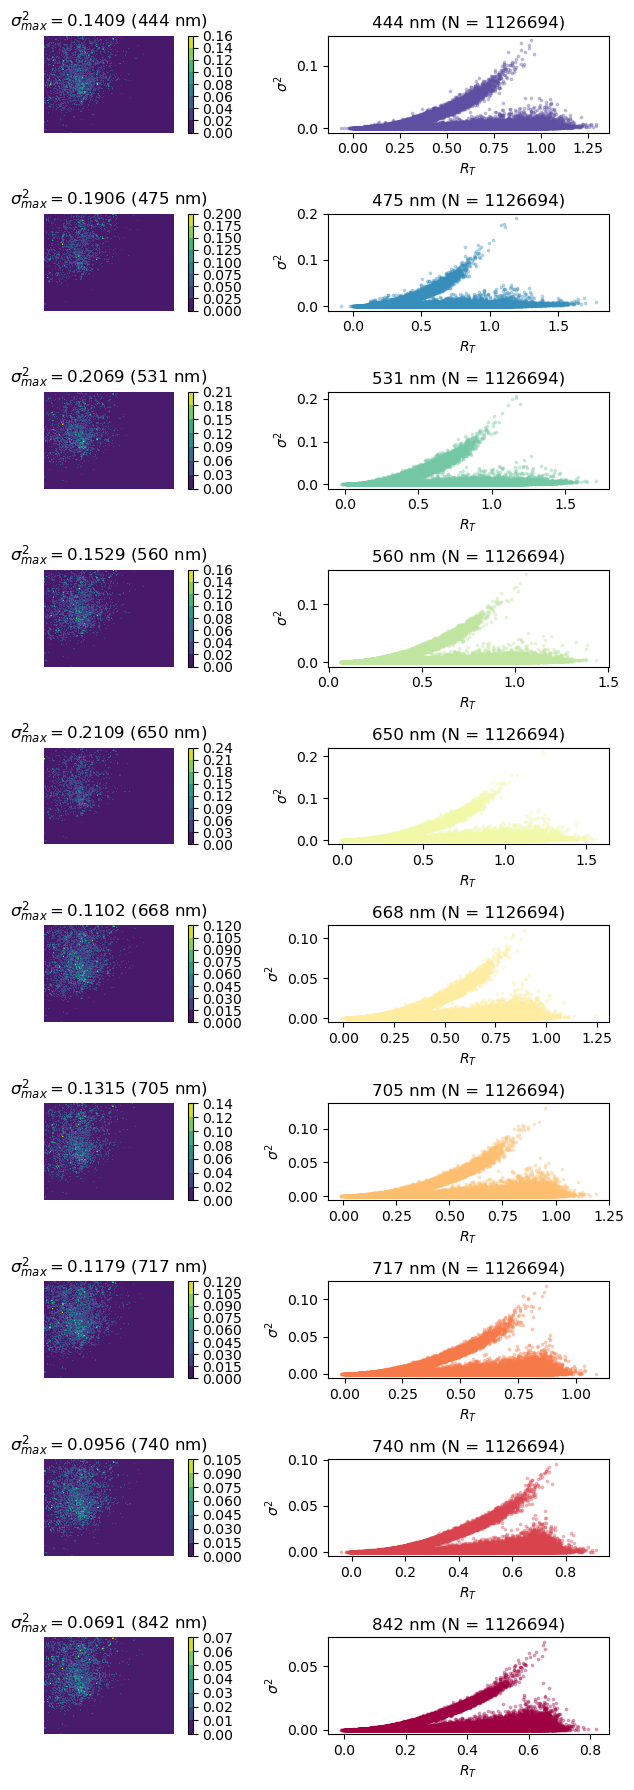

In [35]:
total_uncertainty = UE.get_uncertainty_bounds()

In [40]:
print(f'shape of total uncertainty: {total_uncertainty.shape}')

shape of total uncertainty: (919, 1226, 10)


# Complete SUGAR pipeline

- a new folder in the current directory "saved_plots" will be created with all the saved and processed data

In [5]:
SP = sugar.SUGARpipeline(im_aligned,
                    bbox=[[166, 306], [445, 635]], #bbox only required for Hedley's algo, not required for sugar
                    filename="test")
SP.main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(2, 45264)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
